# 1. Импорт библиотек

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Фиксируем RANDOM SEED и версии пакетов
RANDOM_SEED = 42

# 2. Импорт данных

In [3]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

pd.set_option('display.max_columns', None)

In [4]:
# Тренировочный датасет
display(train.sample(3))

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
70680,37901,14FEB2014,GRD,F,38,N,N,0,0,-2.561445,1,50,1,2,40000,1,3,Y,0
16168,20402,28JAN2014,SCH,M,55,N,N,0,0,-1.920823,1,40,2,3,9000,4,1,N,0
68047,5751,12JAN2014,SCH,F,50,N,N,0,0,-1.397718,3,60,1,2,25000,1,4,N,0


In [5]:
# Тестовый датасет
display(test.sample(3))

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
29793,40856,17FEB2014,SCH,F,38,Y,Y,0,0,-1.339238,0,60,2,3,38000,1,3,N
28593,20570,28JAN2014,UGR,F,36,N,N,0,0,-2.212602,0,50,1,1,25000,1,4,N
16492,66177,15MAR2014,UGR,M,27,N,N,0,0,-1.906771,3,50,1,2,26000,2,1,N


In [6]:
print(f"Датасет имеет {train.shape[1]} столбцов/признаков.")
print(f"Тренировочный датасет состоит из {len(train)} строк.")
print(f"Тестовый датасет состоит из {len(test)} строк.")

Датасет имеет 19 столбцов/признаков.
Тренировочный датасет состоит из 73799 строк.
Тестовый датасет состоит из 36349 строк.


In [7]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
train['Train'] = 1 # помечаем где у нас трейн
test['Train'] = 0 # помечаем где у нас тест

df = train.append(test, sort=False).reset_index(drop=True) # объединяем

# 3. Предварительный анализ данных

In [8]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

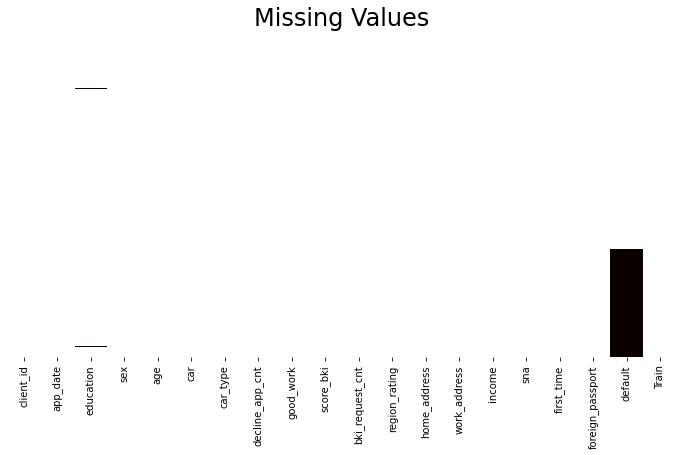

In [9]:
fig = plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(df.isnull(), cbar=False, cmap='hot_r', yticklabels=[]).set_title('Missing Values', fontsize=24)

In [10]:
print(df.isna().sum())

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Train                   0
dtype: int64


Описания полей датасета

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту  

Резюме по предварительному анализу: в тренировочной выборке 73799 клиентов, в тестовой - 36349. Всего данные о 110148 клиентах. Всего 20 переменных, из них 1 - временной ряд, 5 бинарных, 6 категориальных и 7 числовых. Всего пропусков 478, все пропуски в переменной education. client_id уникальный числовой признак, который не несет полезностей. В бинарных признаках наше целевая переменная default и искуственно добавленный признак тренировочной части датасета Train

In [22]:
# внесем данные из резюме в списки 
# временной ряд (1)
time_cols = ['app_date']
# бинарные переменные (default не включаем в список) (5+1 = 6)
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
# категориальные переменные (Train не включаем в список, так как мы сами его добавили) (3+1=4)
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
# числовые переменные, client_id исключили из списка (7)
num_cols = ['age','decline_app_cnt','score_bki','bki_request_cnt','income']
# client_id не включаем в списки

# 4. Анализ переменных

In [69]:
def draw_plot(dataset, parameter):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(dataset[parameter], bins=10, ax=ax[0])
    sns.boxplot(dataset[parameter], ax=ax[1])

In [76]:
def draw_log_plot(dataset, parameter):
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(np.log(dataset[parameter] + 1), bins=10, ax=ax[0])
    sns.boxplot(np.log(dataset[parameter] + 1), ax=ax[1])

In [86]:
def detect_outliers(dataset, parameter):
    perc25 = dataset[parameter].quantile(0.25)
    perc75 = dataset[parameter].quantile(0.75)
    IQR = perc75 - perc25
    print(
        f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75}, IQR: {IQR}, границы выбросов: [{perc25 - 1.5*IQR}; {perc75 + 1.5*IQR}]')

### Анализ числовых переменных.

##### Age

In [47]:
train['age'].describe()

count    73799.000000
mean        39.280641
std         11.520378
min         21.000000
25%         30.000000
50%         37.000000
75%         48.000000
max         72.000000
Name: age, dtype: float64

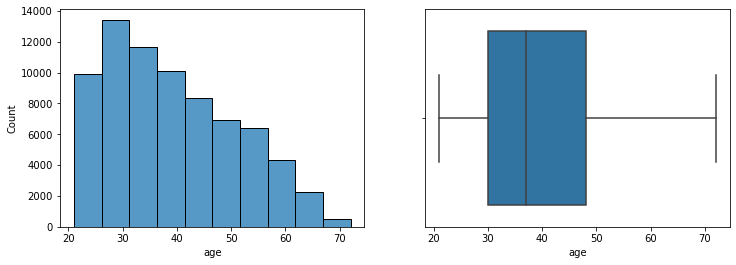

In [70]:
draw_plot(train, 'age')

In [62]:
# Построим графики логарифмированной переменной

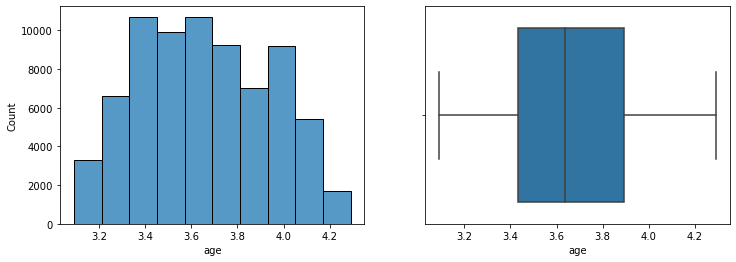

In [77]:
draw_log_plot(train, 'age')

In [64]:
# Распределение логнормальное. Выбросов нет.

##### Decline_app_cnt

In [75]:
train['decline_app_cnt'].describe()

count    73799.000000
mean         0.275749
std          0.804272
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         33.000000
Name: decline_app_cnt, dtype: float64

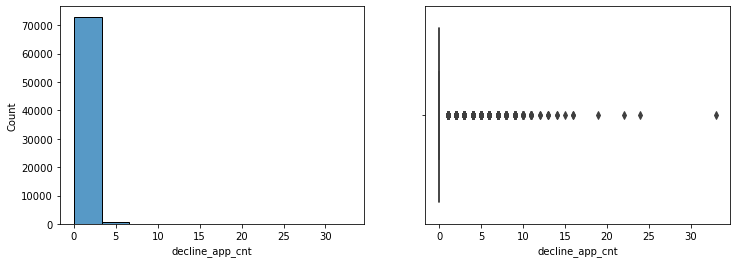

In [72]:
draw_plot(train, 'decline_app_cnt')

In [62]:
# Построим графики логарифмированной переменной

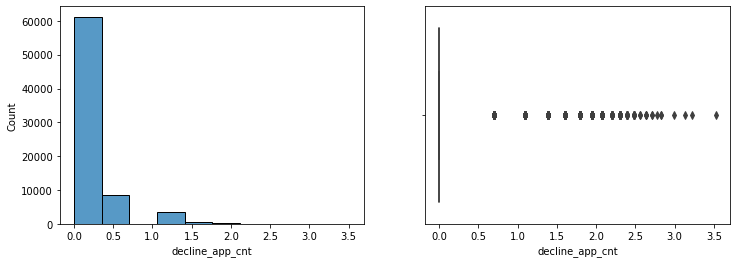

In [78]:
draw_log_plot(train, 'decline_app_cnt')

In [88]:
# Признак имеет большое количество выбросов. Определим границы выбросов.
detect_outliers(train, 'decline_app_cnt')

# Все значения выше нуля за границей выбросов. Оставим все как есть.

25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0, границы выбросов: [0.0; 0.0]
